# QCNN demonstration with Noisy Devices

## 1. Load Noisemodel with IBMQ

Noise Model (Fake Provider)

In [37]:
n_qubits = 4

In [9]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.aer.backends import AerSimulator
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel

IBMQ.load_account()
noisy = FakeJakarta()

noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev_fake = qml.device(
    'qiskit.aer',
    wires=n_qubits,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

ibmqfactory.load_account:WARNING:2023-01-14 16:38:41,539: Credentials are already in use. The existing account in the session will be replaced.


Real device

In [4]:
TOKEN_tak = "798c4f141e8fa071c14823a956f816c8dda622f9f00b95cae62cc5b1a3105b4fe4845a234d661f20281f6b77ac0299e3c4367f6a3b58db16c36bcde3a9cb1151"
TOKEN_dkp = "3ae7ac10f40eb88c7ebb0eca20aa0788e7a96da729e2c3848d9864684362aaf50dfdda7cb3ec1ffd75eb7ed5b44f7c14f2f17419cf600ce14437ee7cd00ac75b"

IBMQ.save_account(token=TOKEN_dkp, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku')
backend = "ibmq_jakarta"

dev_jakarta = qml.device(
    'qiskit.ibmq',
    wires=4,
    shots=1024,
    backend=backend,
    provider=provider
)

ibmqfactory.load_account:WARNING:2023-01-14 16:28:24,690: Credentials are already in use. The existing account in the session will be replaced.


## 2. Feature Mapping Circuits

Create Feature Mapping Circuits. 

Note: This is 4 qubit feature mapping circuits used for demonstration.

Unlike noiseless simulation, last to first qubit CNOT gates are omitted for connectivity.

Also number of layers is set to 1 (N_layers = 3 for noiseless simulation).

In [38]:
import embedding

def Noisy_Four_QuantumEmbedding1(input):
    for j in range(4):
        qml.Hadamard(wires=j)
        embedding.exp_Z(input[j], wires=j)
    for k in range(3):
        embedding.exp_ZZ2(input[k], input[k+1], wires=[k,k+1])
    #exp_ZZ2(input[3], input[0], wires=[3, 0])                  Removed for connectivity

def Noisy_Four_QuantumEmbedding1_inverse(input):
    #exp_ZZ2(input[3], input[0], wires=[3, 0], inverse=True)    Removce for connectivity
    for k in reversed(range(3)):
        embedding.exp_ZZ2(input[k], input[k+1], wires=[k,k+1], inverse=True)
        qml.Barrier()
    for j in range(4):
        embedding.exp_Z(input[j], wires=j, inverse=True)
        qml.Hadamard(wires=j)

# Quantum Embedding 2 for model 2
def Noisy_Four_QuantumEmbedding2(input):
    for j in range(4):
        qml.Hadamard(wires=j)
        embedding.exp_Z(input[j], wires=j)
    for k in range(3):
        embedding.exp_ZZ1(input[4+k], wires=[k, k+1])
    #exp_ZZ1(input[15], wires=[7,0])                        Removed for connectivity

def Noisy_Four_QuantumEmbedding2_inverse(input):
    #embedding.exp_ZZ1(input[15], wires=[7,0], inverse=True) Removed for connectivity
    for k in reversed(range(3)):
        embedding.exp_ZZ1(input[k+4], wires=[k,k+1], inverse=True)
    qml.Barrier()
    for j in range(4):
        embedding.exp_Z(input[j], wires=j, inverse=True)
        qml.Hadamard(wires=j)

In [44]:
import torch
from torch import nn

# Hybrid Model 1
@qml.qnode(dev_fake, interface="torch")
def circuit1(inputs): 
    Noisy_Four_QuantumEmbedding1(inputs[0:4])
    Noisy_Four_QuantumEmbedding1_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

class Noisy_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(circuit1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

# Hybrid Model 2
@qml.qnode(dev_fake, interface="torch")
def circuit2(inputs): 
    Noisy_Four_QuantumEmbedding2(inputs[0:7])
    Noisy_Four_QuantumEmbedding2_inverse(inputs[7:14])
    return qml.probs(wires=range(4))

class Noisy_Model2_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]

In [48]:
print("Circuit1: \n")
print(
    qml.draw(
        circuit1,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,1,2,3,4])
)

print("Circuit2: \n")
print(
    qml.draw(
        circuit2,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
)

Circuit1: 

0: ──H──RZ(-2.00)─╭●────────────╭●────────────────────────────────────────────────────────────
1: ──H──RZ(-4.00)─╰X──RZ(-4.89)─╰X─╭●────────────╭●──────────────────────────────────╭●───────
2: ──H──RZ(-6.00)──────────────────╰X──RZ(-0.32)─╰X─╭●───────────╭●─╭●────────────╭●─╰X───────
3: ──H──RZ(-8.00)───────────────────────────────────╰X──RZ(0.24)─╰X─╰X──RZ(-0.24)─╰X──RZ(8.00)

───────────────╭●──────────────────╭●──RZ(2.00)──H─┤ ╭Probs
────────────╭●─╰X─────────RZ(4.89)─╰X──RZ(4.00)──H─┤ ├Probs
───RZ(0.32)─╰X──RZ(6.00)──H────────────────────────┤ ├Probs
───H───────────────────────────────────────────────┤ ╰Probs
Circuit2: 

0: ──H──RZ(-2.00)─╭●─────────────╭●───────────────────────────────────────────────────────────────
1: ──H──RZ(-4.00)─╰X──RZ(-10.00)─╰X─╭●─────────────╭●────────────────────────────────────╭●───────
2: ──H──RZ(-6.00)───────────────────╰X──RZ(-12.00)─╰X─╭●─────────────╭●─╭●────────────╭●─╰X───────
3: ──H──RZ(-8.00)─────────────────────────────────────╰X──

# 4. Load Datasets

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import data
import training


feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

N_valid, N_test = 500, 1000
X1_new_valid, X2_new_valid, Y_new_valid = training.new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = training.new_data(N_test, X_test, Y_test)

Uisng Device: cpu



TypeError: data_load_and_process() missing 1 required positional argument: 'ROI'

# 5. Train Models

In [13]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Model1_Fidelity':
        model = Model1_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/earlystop 10 experiments/Analysis/Model1_Fidelity.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(200):
        X1_batch, X2_batch, Y_batch = new_data(10, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)


#train_models('Model1_Fidelity')
train_models('Model1_Fidelity')

Iterations: 0 Loss: 0.1334354430437088
Iterations: 1 Loss: 0.181786447763443
Iterations: 2 Loss: 0.39313602447509766
Iterations: 3 Loss: 0.24019566178321838
Iterations: 4 Loss: 0.29357433319091797
Iterations: 5 Loss: 0.34023523330688477
Iterations: 6 Loss: 0.4444909989833832
Iterations: 7 Loss: 0.22131165862083435
Iterations: 8 Loss: 0.4706466794013977
Iterations: 9 Loss: 0.4577895998954773
Iterations: 10 Loss: 0.3147352337837219
Iterations: 11 Loss: 0.44538936018943787
Iterations: 12 Loss: 0.4642656445503235
Iterations: 13 Loss: 0.5150899887084961
Iterations: 14 Loss: 0.04970979690551758
Iterations: 15 Loss: 0.10976314544677734
Iterations: 16 Loss: 0.21642637252807617
Iterations: 17 Loss: 0.2713228166103363
Iterations: 18 Loss: 0.29002076387405396
Iterations: 19 Loss: 0.20271272957324982
Iterations: 20 Loss: 0.3947276175022125
Iterations: 21 Loss: 0.24872808158397675
Iterations: 22 Loss: 0.47777071595191956
Iterations: 23 Loss: 0.2039669007062912
Iterations: 24 Loss: 0.176423460245132

In [15]:
PATH = '/Users/tak/Github/QEmbedding/Results/earlystop 10 experiments/Analysis/Model1_Fidelity.pt'
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train), torch.tensor(X0_train)


dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface="torch")
def Four_Distance(inputs): 
    Four_QuantumEmbedding(inputs[0:4])
    return qml.density_matrix(wires=range(4))

class Distances(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(Four_Distance, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x0, Distance, Trained):
        if Trained:
            x1 = self.linear_relu_stack1(x1)
            x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        if Distance == 'Trace':
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))

Model1_Fidelity_Distance = Distances()
Model1_Fidelity_Distance.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
# Distances Before Training
Trace_before_traindata = Model1_Fidelity_Distance(X1_train, X0_train, 'Trace', False)
Trace_before_testdata = Model1_Fidelity_Distance(X1_test, X0_test, 'Trace', False)
print(f"Trace Distance (Training Data) Before: {Trace_before_traindata}")
print(f"Trace Distance (Test Data) Before: {Trace_before_testdata}")

# Distances After training with Model1_Fidelity
Trace_Fidelity_traindata = Model1_Fidelity_Distance(X1_train, X0_train, 'Trace', True)
Trace_Fidelity_testdata = Model1_Fidelity_Distance(X1_test, X0_test, 'Trace', True)
print(f"Trace Distance (Training Data) After Model1 Fidelity: {Trace_Fidelity_traindata}")
print(f"Trace Distance (Test Data) After Model1 Fidelity: {Trace_Fidelity_testdata}")

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) Before: 0.3409276604652405
Trace Distance (Test Data) Before: 0.31724295020103455
Trace Distance (Training Data) After Model1 Fidelity: 0.9015634655952454
Trace Distance (Test Data) After Model1 Fidelity: 0.9096429347991943


## 6. Training QCNN

In [17]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [18]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

model = x_transform()
model.load_state_dict(torch.load(PATH))
#model.load_state_dict(torch.load(PATH_Model1_HSinner, map_location=device))

<All keys matched successfully>

In [30]:
def statepreparation(x, Trained):
    if Trained:
        x = model(torch.tensor(x))
    Four_QuantumEmbedding(x)

def SU_4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

def U_TTN(params, wires):  # 2 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def QCNN_four(params):
    param1 = params[0:2]
    param2 = params[2:4]
    U_TTN(param1, wires=[0, 1])
    U_TTN(param1, wires=[2, 3])
    U_TTN(param1, wires=[1, 2])
    U_TTN(param1, wires=[3, 0])
    U_TTN(param2, wires=[0, 2])


@qml.qnode(dev_fake)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    qml.Barrier()
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 400
learning_rate = 0.01
batch_size = 10
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(4, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [31]:
print(
    qml.draw(
        QCNN_classifier,
        expansion_strategy="device",
        show_matrices=False
    )(x=torch.ones(4), params=np.ones(30), Trained=True)
)

0: ──H──RZ(0.40)──╭●─────────────╭●──RY(1.00)──────────────────────────╭●───────────RY(1.00)
1: ──H──RZ(-0.12)─╰X──RZ(-20.57)─╰X─╭●────────────────────╭●──RY(1.00)─╰X───────────RY(1.00)
2: ──H──RZ(-0.22)───────────────────╰X─────────RZ(-18.67)─╰X─╭●────────────────────╭●───────
3: ──H──RZ(-0.27)────────────────────────────────────────────╰X─────────RZ(-18.22)─╰X───────

────────────────────────────╭X──RY(1.00)─╭●─┤     
─────────────────────────╭●─│────────────│──┤     
───RY(1.00)─╭●──RY(1.00)─╰X─│───RY(1.00)─╰X─┤  <Z>
───RY(1.00)─╰X──RY(1.00)────╰●──────────────┤     


/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
loss_not_trained, weights_not_trained = circuit_training(X_train, Y_train, False)
loss_trained, weights_trained = circuit_training(X_train, Y_train, True)

iteration:  0  cost:  0.49775390625
iteration:  10  cost:  0.43896484375
iteration:  20  cost:  0.515625
iteration:  30  cost:  0.456640625
iteration:  40  cost:  0.50390625
iteration:  50  cost:  0.483984375
iteration:  60  cost:  0.491796875
iteration:  70  cost:  0.527734375
iteration:  80  cost:  0.480859375
iteration:  90  cost:  0.539453125
iteration:  100  cost:  0.42060546875
iteration:  110  cost:  0.46826171875
iteration:  120  cost:  0.4822265625
iteration:  130  cost:  0.53662109375
iteration:  140  cost:  0.46669921875
iteration:  150  cost:  0.50283203125
iteration:  160  cost:  0.5205078125
iteration:  170  cost:  0.520703125
iteration:  180  cost:  0.46220703125
iteration:  190  cost:  0.5076171875
iteration:  200  cost:  0.525
iteration:  210  cost:  0.5591796875
iteration:  220  cost:  0.4814453125
iteration:  230  cost:  0.48974609375
iteration:  240  cost:  0.5005859375
iteration:  250  cost:  0.478515625
iteration:  260  cost:  0.52353515625
iteration:  270  cost: 

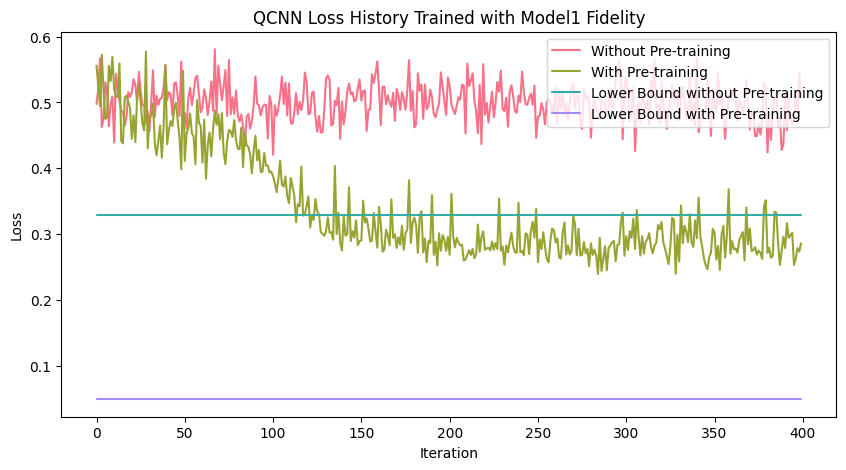

In [34]:
LB_before_traindata = 0.5 * (1 - 0.3409276604652405)
LB_Fidelity_traindata = 0.5 * (1 - 0.9015634655952454)

import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_not_trained)), loss_not_trained, label="Without Pre-training", c=clrs[0])

    ax.plot(range(len(loss_trained)), loss_trained, label="With Pre-training", c=clrs[1])

    ax.plot(range(400), np.ones(400) * LB_before_traindata, label="Lower Bound without Pre-training", c=clrs[2])
    ax.plot(range(400), np.ones(400) * LB_Fidelity_traindata, label="Lower Bound with Pre-training", c=clrs[3])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Trained with Model1 Fidelity")
ax.legend()

In [35]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


predictions_trained = [QCNN_classifier(weights_trained, x, Trained=True) for x in X_test]
predictions_not_trained = [QCNN_classifier(weights_not_trained, x, Trained=False) for x in X_test]

accuracy_trained = accuracy_test(predictions_trained, Y_test)
accuracy_not_trained = accuracy_test(predictions_not_trained, Y_test)

In [36]:
print(f" accuracty after pre-training: {accuracy_trained}")
print(f" accuracty without pre-training: {accuracy_not_trained}")

 accuracty after pre-training: 0.9843971631205674
 accuracty without pre-training: 0.5583924349881797
